In [43]:
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [44]:
# early stopping 
class EarlyStopping():
    def __init__(self,
                 threshold,
                 tolerence) -> None:
        self.threshold = threshold
        self.tolerence = tolerence
        self.counter = 0
    
    def check(self, train_loss, val_loss):
        if val_loss - train_loss >= self.threshold:
            print(f"Incremented at {train_loss}, {val_loss}")
            self.counter += 1
            if self.counter > self.tolerence:
                return True
        else:
            self.counter = 0
        return False

In [45]:
# defining a model
class MLP(nn.Module):
    def __init__(self, p=0.5)  -> None:
        super(MLP, self).__init__()
        self.layers = nn.Sequential(nn.Flatten(),
                                    nn.Linear(28 * 28 * 1, 1024),      
                                    nn.Dropout(p=p),
                                    nn.ReLU(),
                                    nn.Linear(1024, 512),
                                    nn.Dropout(p=p),
                                    nn.ReLU(),
                                    nn.Linear(512, 32),
                                    nn.Dropout(p=p),
                                    nn.ReLU(),
                                    nn.Linear(32, 10))

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [46]:
# to find accuracy on the dataset
def test(model, test_dataloader, loss_function):
    tot_loss = 0
    correct_pred = 0
    data_no = 0
    model = model.eval()
    for i, data in enumerate(test_dataloader, 0):
        inputs, targets = data
        inputs = inputs.cuda()
        outputs = model(inputs)
        outputs = outputs.cpu()
        loss = loss_function(outputs, targets)
        tot_loss += loss.item()*targets.shape[0]
        pred_labels = torch.argmax(outputs, dim=1).reshape(-1)
        targets = targets.reshape(-1)
        correct_pred += torch.sum(pred_labels == targets)
        data_no += targets.shape[0]
    print(f'Test loss {tot_loss/data_no}, accuracy {correct_pred/data_no}')
    return tot_loss/data_no, correct_pred/data_no

In [47]:
# function for plotting
def plot_losses(train_losses, test_losses, ax, title):
    ax.set_xlabel('iteration/epoch no')
    ax.set_ylabel('loss')
    iterations = np.arange(len(train_losses))
    epochs = np.arange(len(test_losses))
    ax.plot(iterations, train_losses, label="train loss for " + title)
    ax.plot(epochs, test_losses, label="test loss for " + title)
    ax.legend()

def plot_accuracies(accuracies, ax, title):
    epochs = np.arange(len(accuracies))
    ax.plot(epochs, accuracies, label="test accuracy for " + title)
    ax.legend()

In [48]:
# main function for comaparing the effect of dropout
def main_early_stopping(epochs=5, 
                        batch_size=10, 
                        ax1=None, 
                        ax2=None,
                        is_early=True):      
  # Set fixed random number seed
  torch.manual_seed(42)
  
  # Prepare CIFAR-10 dataset
  train_dataset = MNIST(os.getcwd(),
                        train=True,
                        download=True, 
                        transform=transforms.ToTensor())
  test_dataset = MNIST(os.getcwd(),
                       train=False,
                       download=True,
                       transform=transforms.ToTensor())
  trainloader = torch.utils.data.DataLoader(train_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True
                                            )
  testloader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           )

  # Initialize the MLP
  mlp = MLP(p=0).cuda()
  
  # Define the loss function and optimizer
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
  accuracies = []
  train_losses = []
  test_losses = []
  early_stop = EarlyStopping(0.001, tolerence=15)

  # Run the training loop
  for epoch in range(epochs): # 5 epochs at maximum    
    current_loss = 0.0
    epoch_loss = 0.0
    data_no = 0.0
    # if epoch == 0:
    #   test_loss, accuracy = test(mlp, testloader, loss_function)
    # test_losses.append(test_loss)
    # accuracies.append(accuracy) 
    mlp = mlp.train()
    # Iterate over the DataLoader for training data
    loop = tqdm(enumerate(trainloader, 0), total=len(trainloader))
    for i, data in loop:
      inputs, targets = data
      inputs = inputs.cuda()
      optimizer.zero_grad()
      outputs = mlp(inputs)
      outputs = outputs.cpu()
      loss = loss_function(outputs, targets)
      loss.backward()
      optimizer.step()
      current_loss += loss.item()
      epoch_loss += loss.item()*targets.shape[0]
      data_no += targets.shape[0]
      if i % max(int(500*(10/batch_size)), 1) == max(int((500*10/batch_size))-1, 0):
          loop.set_description(f'Epoch no {epoch}')
          loop.set_postfix_str(f'Loss after {i+1}th minibatch: {round(current_loss, 2)}')
          # print('Loss after mini-batch %5d: %.3f' %
          #       (i + 1, current_loss / 500))
          current_loss = 0.0
    train_losses.append(epoch_loss/data_no)
    print(f"Train loss {epoch_loss/data_no}")
    test_loss, accuracy = test(mlp, testloader, loss_function)
    test_losses.append(test_loss)
    accuracies.append(accuracy) 
    if is_early:
      if early_stop.check(epoch_loss/data_no, test_loss):
            print(f"Stopping early at {epoch} epoch")
            break 
  title = f" earlystop" if is_early else " w/o earlystop"
  plot_losses(train_losses, test_losses, ax1, title)
  plot_accuracies(accuracies, ax2, title)
  # Process is complete.
  print('Training process has finished.')

  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.6922905190229416
Test loss 0.2671815396308899, accuracy 0.9207000136375427


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.23059694436391195
Test loss 0.18121679973602295, accuracy 0.9462000131607056


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.15490252708594004
Test loss 0.13557558531761169, accuracy 0.9581999778747559


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.11641225678126017
Test loss 0.11911235554218293, accuracy 0.9629999995231628
Incremented at 0.11641225678126017, 0.11911235554218293


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.08779047961235047
Test loss 0.09834123198986053, accuracy 0.9688000082969666
Incremented at 0.08779047961235047, 0.09834123198986053


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.06835397092501322
Test loss 0.08707780066728592, accuracy 0.9729999899864197
Incremented at 0.06835397092501322, 0.08707780066728592


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.05520719936688741
Test loss 0.08009989447593689, accuracy 0.9763000011444092
Incremented at 0.05520719936688741, 0.08009989447593689


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.044923298984766005
Test loss 0.07290133014917374, accuracy 0.9764000177383423
Incremented at 0.044923298984766005, 0.07290133014917374


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.03554115667939186
Test loss 0.0709077486038208, accuracy 0.9779000282287598
Incremented at 0.03554115667939186, 0.0709077486038208


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.02929356518983841
Test loss 0.07122161427736283, accuracy 0.9793999791145325
Incremented at 0.02929356518983841, 0.07122161427736283


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.022449117965002853
Test loss 0.07070438976287842, accuracy 0.9790999889373779
Incremented at 0.022449117965002853, 0.07070438976287842


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.018064526850978535
Test loss 0.06915132513046264, accuracy 0.9796000123023987
Incremented at 0.018064526850978535, 0.06915132513046264


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.015060363930463791
Test loss 0.06687109904289246, accuracy 0.9796000123023987
Incremented at 0.015060363930463791, 0.06687109904289246


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.011930238923927148
Test loss 0.07138455109596252, accuracy 0.980400025844574
Incremented at 0.011930238923927148, 0.07138455109596252


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.009136296570797762
Test loss 0.06920496764183044, accuracy 0.9807000160217285
Incremented at 0.009136296570797762, 0.06920496764183044


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0075636799861987436
Test loss 0.07277757799625396, accuracy 0.9803000092506409
Incremented at 0.0075636799861987436, 0.07277757799625396


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0067006828824679055
Test loss 0.07072699935436248, accuracy 0.9807999730110168
Incremented at 0.0067006828824679055, 0.07072699935436248


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0044878551177680494
Test loss 0.07583066654205323, accuracy 0.9799000024795532
Incremented at 0.0044878551177680494, 0.07583066654205323


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.004311835327992837
Test loss 0.07138474003076553, accuracy 0.9814000129699707
Incremented at 0.004311835327992837, 0.07138474003076553
Stopping early at 18 epoch
Training process has finished.


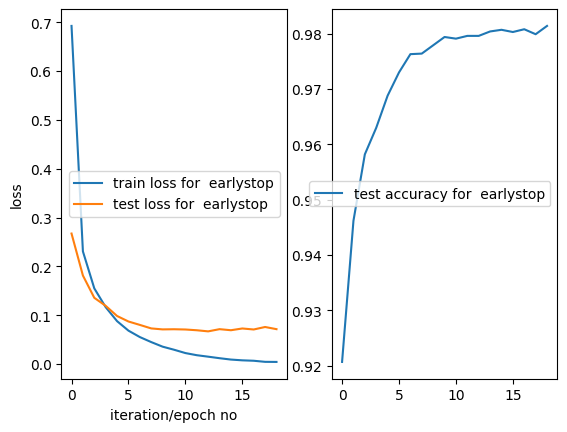

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2)
main_early_stopping(50, 1024, ax1, ax2, True)

  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.6922905190229416
Test loss 0.2671815396308899, accuracy 0.9207000136375427


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.23059694436391195
Test loss 0.18121679973602295, accuracy 0.9462000131607056


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.15490252708594004
Test loss 0.13557558531761169, accuracy 0.9581999778747559


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.11641225678126017
Test loss 0.11911235554218293, accuracy 0.9629999995231628


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.08779047961235047
Test loss 0.09834123198986053, accuracy 0.9688000082969666


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.06835397092501322
Test loss 0.08707780066728592, accuracy 0.9729999899864197


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.05520719936688741
Test loss 0.08009989447593689, accuracy 0.9763000011444092


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.044923298984766005
Test loss 0.07290133014917374, accuracy 0.9764000177383423


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.03554115667939186
Test loss 0.0709077486038208, accuracy 0.9779000282287598


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.02929356518983841
Test loss 0.07122161427736283, accuracy 0.9793999791145325


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.022449117965002853
Test loss 0.07070438976287842, accuracy 0.9790999889373779


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.018064526850978535
Test loss 0.06915132513046264, accuracy 0.9796000123023987


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.015060363930463791
Test loss 0.06687109904289246, accuracy 0.9796000123023987


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.011930238923927148
Test loss 0.07138455109596252, accuracy 0.980400025844574


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.009136296570797762
Test loss 0.06920496764183044, accuracy 0.9807000160217285


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0075636799861987436
Test loss 0.07277757799625396, accuracy 0.9803000092506409


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0067006828824679055
Test loss 0.07072699935436248, accuracy 0.9807999730110168


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0044878551177680494
Test loss 0.07583066654205323, accuracy 0.9799000024795532


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.004311835327992837
Test loss 0.07138474003076553, accuracy 0.9814000129699707


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.004205347775916258
Test loss 0.0863474924325943, accuracy 0.9803000092506409


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0033234983826677003
Test loss 0.07444653961658478, accuracy 0.9824000000953674


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.001329832146471987
Test loss 0.07473553982973098, accuracy 0.9822999835014343


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0008436840258538722
Test loss 0.0750515127658844, accuracy 0.9825000166893005


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0006549607415373127
Test loss 0.07584849858283997, accuracy 0.9825000166893005


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0005589577209204436
Test loss 0.07670248789787293, accuracy 0.9825999736785889


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0004602778134867549
Test loss 0.07702529728412628, accuracy 0.9832000136375427


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00043337855787637335
Test loss 0.07913266649246216, accuracy 0.9825000166893005


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00037035783560325703
Test loss 0.08016109368801116, accuracy 0.9825000166893005


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0003336271752137691
Test loss 0.08025055609941482, accuracy 0.9819999933242798


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0003054429283676048
Test loss 0.08069982920885085, accuracy 0.982699990272522


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00028201163463915387
Test loss 0.0816513177394867, accuracy 0.982699990272522


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00025720930113457143
Test loss 0.08143270354270934, accuracy 0.9829999804496765


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0002378497129228587
Test loss 0.08166155377626419, accuracy 0.9830999970436096


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0002144422284560278
Test loss 0.08383343396186829, accuracy 0.9824000000953674


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00019940316127613187
Test loss 0.08409604932069778, accuracy 0.9828000068664551


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00018697171645859877
Test loss 0.0844496770977974, accuracy 0.9824000000953674


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00017403521372471006
Test loss 0.08485609431266784, accuracy 0.9825999736785889


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00016110949392120043
Test loss 0.08624810934066772, accuracy 0.9825999736785889


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00015082851227295275
Test loss 0.08591969225406647, accuracy 0.982699990272522


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00014157799373691282
Test loss 0.08661243835687638, accuracy 0.9824000000953674


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00013133867270080372
Test loss 0.08715504423379898, accuracy 0.9824000000953674


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00012718316961545496
Test loss 0.08758819628953934, accuracy 0.9825999736785889


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00011686601324472577
Test loss 0.08797756592035294, accuracy 0.9825999736785889


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00010984871612939363
Test loss 0.08857508071660995, accuracy 0.9825999736785889


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00010356384015952547
Test loss 0.08899590482711792, accuracy 0.9824000000953674


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 9.744389588013292e-05
Test loss 0.08951612536907196, accuracy 0.9825000166893005


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 9.216395273494224e-05
Test loss 0.08965914767980576, accuracy 0.9825999736785889


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 8.743757591582834e-05
Test loss 0.09052774795293808, accuracy 0.9825999736785889


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 8.185242431548734e-05
Test loss 0.09077399879693986, accuracy 0.9824000000953674


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 7.73251978176025e-05
Test loss 0.09125325417518616, accuracy 0.982699990272522
Training process has finished.


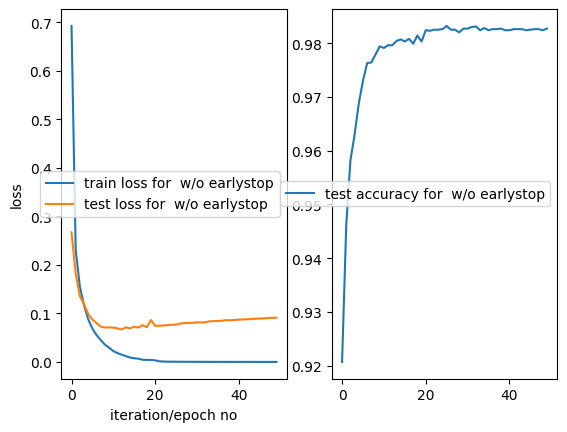

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2)
main_early_stopping(50, 1024, ax1, ax2, False)